# Customer Lifetime Value Prediction

## 1. Directory, Libraries and Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Learning/Business Analyst Course/Segmentation/RFM

/content/drive/MyDrive/Learning/Business Analyst Course/Segmentation/RFM


In [ ]:
#import libraries 
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division

from datetime import datetime, timedelta,date
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

In [ ]:
#Data
data = pd.read_csv('online_shoppers.csv',
                   encoding = "ISO-8859-1").dropna()
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
separator = '\n*******************************\n'
print(data.info())
print(separator)
print(data.describe())
print(separator)
print(data.head(5))
print(separator)
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB
None

*******************************

            Quantity      UnitPrice     CustomerID
count  406829.000000  406829.000000  406829.000000
mean       12.061303       3.460471   15287.690570
std       248.693370      69.315162    1713.600303
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13953.000000
50%         5.000000       1.950000   15152.000000
7

## 2. Data Preparation

In [ ]:
#Creating Sales column
data['sales'] = data['Quantity'] * data['UnitPrice']
data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sales,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3,201012


In [ ]:
#Convert the type of Invoice Date Field from string to datetime.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
#Creat YearMonth field for the ease of reporting and visualization
data['InvoiceYearMonth'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.month)

In [ ]:
data['Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [ ]:
# in this case focus using UK data
data_uk = data.query("Country=='United Kingdom'").reset_index(drop=True)

Segmentation Techniques

RFM represents a method used for measuring customer value. An RFM analysis can show ***who are the most valuable customers for the business***. The ones who buy most frequently, most often, and spend the most. 

The purpose of RFM analysis is to enable marketers to increase revenue by targeting specific groups of existing customers with messages and offers that are more likely to be relevant based on data about a particular set of behaviors. 

Theoretically we will have segments like below:
*  **Low Value**: Customers who are less active than others, are not very frequent buyer/visitor, and generates very low - zero - maybe negative revenue.
*  **Mid Value**: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequently and generates moderate revenue.
* **High Value**: The group we don’t want to lose. High Revenue, Frequency, and low Inactivity.

As the methodology, we need to calculate Recency, Frequency, and Monetary Value (we will call it Revenue from now on) and apply unsupervised machine learning to identify different groups (clusters) for each. Let’s jump into coding and see how to do RFM Clustering.

## 3. Recency 

To calculate recency,  need to find out the most recent purchase date of each customer and see how many days they are inactive. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [ ]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
data_user = pd.DataFrame(data['CustomerID'].unique())
data_user.columns = ['CustomerID']
data_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


To calculate recency, we need to know when last the person bought something. 

In [ ]:
#get the max purchase date for each customer and create a dataframe with it
data_max_purchase = data_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
data_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
data_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [ ]:
# Compare the last transaction of the dataset with last transaction dates of the individual customer IDs.
data_max_purchase['Recency'] = (data_max_purchase['MaxPurchaseDate'].max() - data_max_purchase['MaxPurchaseDate']).dt.days
data_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [ ]:
# merge to new user dataframe
data_user = pd.merge(data_user, data_max_purchase[['CustomerID','Recency']], on='CustomerID')
data_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


### 3.1 Calculate Recency score

To clustering recency scores using going to apply K-means clustering.  Before that,  we should know how many clusters we need for to K-means algorithm. Apply the Elbow Method to find out, Elbow Method is simple to tell the optimal cluster number for optimal inertia. 

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

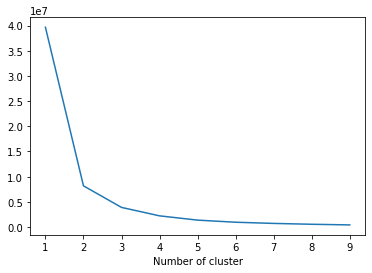

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
data_recency = data_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_recency)
    data_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

3 is the optimal one. Based on business requirements, will be selecting 4 for this case

In [ ]:
# build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
data_user['RecencyCluster'] = kmeans.fit_predict(data_user[['Recency']])

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
data_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,3
2,13748.0,95,0
3,15100.0,329,1
4,15291.0,25,3


In [ ]:
data_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
1,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
2,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


### 3.2 Ordering Recency clusters

Because the cluster arrangement is random and there are no levels, Cluster 2 is not better than cluster 1 for e.g. and so on. We want to give clusters according to the most recent transactions.

The first stage is to find the mean of recency values corresponding to each cluster and then sort these values based on the mean.

In [ ]:
# Ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

data_user = order_cluster('RecencyCluster', 'Recency',data_user,False)

In [ ]:
data_user.tail()

,CustomerID,Recency,RecencyCluster
3945,15942.0,133,1
3946,14143.0,133,1
3947,16147.0,133,1
3948,15149.0,133,1
3949,15776.0,132,1


In [ ]:
data_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


Cluster 0 now is the most inactive, cluster 3 is the most active.

## 4. Frequency

Untuk membuat kelompok frekuensi, temukan jumlah total pesanan untuk setiap pelanggan.

In [ ]:
# Order counts for each user and create dataframe
data_frequency = data_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
data_frequency.columns = ['CustomerID','Frequency']

In [ ]:
data_frequency.head() # how many orders customer have

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [ ]:
#add this data to main dataframe
data_user = pd.merge(data_user, data_frequency, on='CustomerID')
data_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


### 4.1 Calculate Frequency Clusters
<br>Determine the right number of clusters for K-Means by elbow method

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-48-4136cb3e65dd>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-48-4136cb3e65dd>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

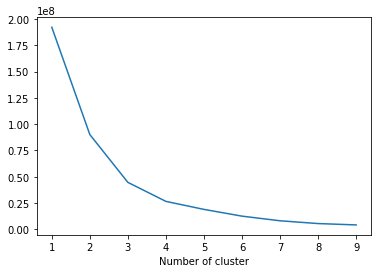

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
data_recency = data_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_recency)
    data_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

By the Elbow method clusters, the best number it is 4, after that graph goes down.

### 4.2 Ordering Frequency Clusters

In [ ]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
data_user['FrequencyCluster']=kmeans.fit_predict(data_user[['Frequency']])

#order the frequency cluster
data_user = order_cluster('FrequencyCluster', 'Frequency', data_user, True )
data_user.groupby('FrequencyCluster')['Frequency'].describe()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


The cluster with max frequency is cluster 3, least frequency cluster is cluster 0.

## 5. Revenue

### 5.1 Calculate Revenue Cluster

In [ ]:
#calculate revenue for each customer
data_uk['Revenue'] = data_uk['UnitPrice'] * data_uk['Quantity']
data_revenue = data_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [ ]:
data_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [ ]:
#merge it with our main dataframe
data_user = pd.merge(data_user, data_revenue, on='CustomerID')
data_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,14688.0,7,3,359,1,5107.38
4,16029.0,38,3,274,1,50992.61


Same with frequency and Recency using The Elbow method to find out the optimum number of clusters for K-Means

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-53-5abfc30ee83d>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-53-5abfc30ee83d>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

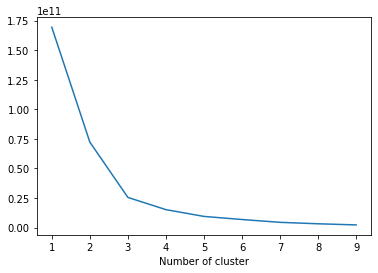

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
data_recency = data_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_recency)
    data_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

From the elbow's method, we find that clusters can be three or four. Let's take 4 as the number of clusters

### 5.2 Ordering Revenue Cluster 

In [ ]:
#apply clustering
kmeans = KMeans(n_clusters=4)
data_user['RevenueCluster'] = kmeans.fit_predict(data_user[['Revenue']])

#order the cluster numbers
data_user = order_cluster('RevenueCluster', 'Revenue',data_user,True)

#show details of the dataframe
data_user.groupby('RevenueCluster')['Revenue'].describe()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


Cluster 3 is the biggest revenue , while cluster 0 has the lowest revenue. 

## 6. Score based on RFM Clustering

In [ ]:
#calculate all score and use mean() to see details
data_user['OverallScore'] = data_user['RecencyCluster'] + data_user['FrequencyCluster'] + data_user['RevenueCluster']
data_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

<ipython-input-57-d921de5fc222>:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


The highest score number 8 is the best customer, and a score of 0 is our worst customer.

In [ ]:
data_user['Segment'] = 'Low-Value'
data_user.loc[data_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
data_user.loc[data_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [ ]:
data_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


## 7. Customer Lifetime Value

For the next step calculate 6 months LTV for each customer which we are going to use for training our model.

**Lifetime Value: Total Gross Revenue - Total Cost**

There is no cost specified in the dataset. That’s why Revenue becomes our LTV directly.

In [ ]:
data_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sales,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,201012,20.34


In [ ]:
data_uk['InvoiceDate'].describe()

<ipython-input-61-a372fa674ee4>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  361878
unique                  18441
top       2011-11-14 15:27:00
freq                      543
first     2010-12-01 08:26:00
last      2011-12-09 12:49:00
Name: InvoiceDate, dtype: object

See that customers are active since 1 December 2010. 
Consider customers from March onwards (so that they are not new customers). Divide into 2 subgroups. One will be where the timeframe of analyzing is 3 months, another will be a timeframe of 6 months.

In [ ]:
tx_3m = data_uk[(data_uk.InvoiceDate < pd.Timestamp(date(2011,6,1))) & (data_uk.InvoiceDate >= pd.Timestamp(date(2011,3,1)))].reset_index(drop=True) #3 months time
tx_6m = data_uk[(data_uk.InvoiceDate >= pd.Timestamp(date(2011,6,1))) & (data_uk.InvoiceDate < pd.Timestamp(date(2011,12,1)))].reset_index(drop=True) # 6 months time

In [ ]:
#calculate revenue and create a new dataframe
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

In [ ]:
tx_user_6m.head()

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


In [ ]:
#plot LTV histogram
plot_data = [
    go.Histogram(
        x=tx_user_6m['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

The histogram clearly shows customers that have negative LTV, and there is some outlier. Filtering out the outliers makes sense to have a proper machine learning model.

For the next step merge our 3 months and data_uk and also merge 6 months data frame and data_uk to see correlations between LTV and the feature set we have.

In [ ]:
data_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


In [ ]:
data_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sales,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,201012,20.34


In [ ]:
#Only people who are in the timeline of tx_user_6m
tx_merge = pd.merge(data_user, tx_user_6m, on='CustomerID', how='left') 

In [ ]:
tx_merge = tx_merge.fillna(0)

In [ ]:
tx_graph = tx_merge.query("m6_Revenue < 50000") # max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Visualize the correlation between overall RFM score and revenue. A positive correlation is quite visible here. A high RFM score means a high LTV.

LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.

Considering the business part of this analysis, we need to treat customers differently based on their predicted LTV. For this example, we will apply clustering and have 3 segments (the number of segments really depends on your business dynamics and goals):

Low LTV
Mid LTV
High LTV

and apply K-means clustering to decide on segments and observe their characteristics

In [ ]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [ ]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value,0.00
1,14688.0,7,3,359,1,5107.38,1,5,High-Value,1702.06
4,14849.0,21,3,392,1,7904.28,1,5,High-Value,5498.07
6,13468.0,1,3,306,1,5656.75,1,5,High-Value,1813.09
7,17690.0,29,3,258,1,4748.45,1,5,High-Value,2616.15


In [ ]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
tx_merge['LTVCluster'] = kmeans.fit_predict(tx_merge[['m6_Revenue']])

tx_merge.head()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value,0.00,0
1,14688.0,7,3,359,1,5107.38,1,5,High-Value,1702.06,2
4,14849.0,21,3,392,1,7904.28,1,5,High-Value,5498.07,1
6,13468.0,1,3,306,1,5656.75,1,5,High-Value,1813.09,2
7,17690.0,29,3,258,1,4748.45,1,5,High-Value,2616.15,2


In [ ]:
# order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,2961.0,277.521186,282.260067,-4287.63,0.0000,229.230,453.06,941.95
1,793.0,1610.428827,549.269666,943.16,1148.9400,1483.140,1949.58,3113.70
2,156.0,4645.661795,1345.674897,3129.27,3537.7325,4256.115,5497.98,8432.68


Before training the machine learning model do few more steps before that
*   Data Preparation
*   Convert categorical columns to numerical columns
*   Check the correlation of features against our label, LTV clusters.
*   Split our feature set and label (LTV) as X and y. We use X to predict y.
*   create Training and Test dataset. A training set will be used for building the machine-learning model. And apply our model to the Test set to see its real performance.

In [ ]:
tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value,0.0,0
1,13093.0,266,0,170,0,7741.47,1,1,Low-Value,0.0,0
2,15032.0,255,0,55,0,4464.10,1,1,Low-Value,0.0,0
3,16000.0,2,3,9,0,12393.70,1,4,Mid-Value,0.0,0
4,15749.0,234,1,15,0,21535.90,1,2,Low-Value,0.0,0


### 7.1 Data Preparation

In [ ]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster) #There is only one categorical variable segment
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850.0,301,0,312,1,5288.63,1,2,0.0,0,0,1,0
1,13093.0,266,0,170,0,7741.47,1,1,0.0,0,0,1,0
2,15032.0,255,0,55,0,4464.10,1,1,0.0,0,0,1,0
3,16000.0,2,3,9,0,12393.70,1,4,0.0,0,0,0,1
4,15749.0,234,1,15,0,21535.90,1,2,0.0,0,0,1,0


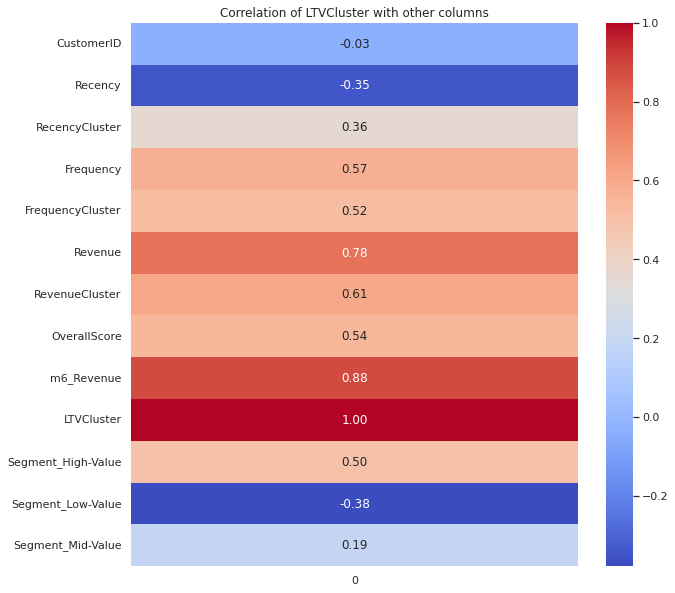

In [ ]:
# Set the factor you want to correlate with the other columns
factor = 'LTVCluster'

# Compute the correlation matrix
corr_matrix = tx_class.corrwith(tx_class[factor])

# Create a heatmap of the correlation matrix using Seaborn
sns.set(style="white")
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix.to_frame(), cmap='coolwarm', annot=True, fmt='.2f', ax=ax)
plt.title("Correlation of {} with other columns".format(factor))
plt.show()

In [ ]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

## 8. Machine Learning Model for Customer Lifetime Value Prediction

In [ ]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)

Accuracy of XGB classifier on training set: 0.95
Accuracy of XGB classifier on test set: 0.92


Accuracy on training and test set is high. 
Will check the precision, recall, fscore 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       145
           1       0.80      0.84      0.82        43
           2       0.88      0.88      0.88         8

    accuracy                           0.92       196
   macro avg       0.88      0.89      0.88       196
weighted avg       0.92      0.92      0.92       196



* Cluster 0: Good precision, recall, f1-score and support
* Cluster 1: Needs better precision, recall and f1-score
* Cluster 2: Bad precision, F1-Score needs improvement

If the model tells this customer belongs to cluster 0, 93 out of 100 will be correct (precision). And the model successfully identifies 95% of actual cluster 0 customers (recall).